# Goal

* calculating phylosignal of each OTU abundances
* using residuals from `abundanance ~ diet_components` regression

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# otu residuals 
otu_file = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/physeq_IndD_OTU-diet-resid.RDS'

# host tree
host_tree_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD.nwk'

# params
threads = 12
sparsity_cutoff = 0.05

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ape)
library(phyloseq)
library(phylosignal)
library(doParallel)

source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 
source('/ebio/abt3_projects/Georg_animal_feces/code/itol.R')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [3]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/ 


## Functions

In [6]:
# phylosignal analysis on each tree subsample
phyloSignal_each = function(i, tree_4d, methods='all', reps=99){
    # phylosignal
    physig_res = phyloSignal(tree_4d[[i]], methods=methods, reps=reps)
    
    # formatting output
    tmp1 = physig_res$stat 
    tmp1$OTU = rownames(tmp1)

    # calculating qvalue on results
    tmp2 = physig_res$pvalue
    tmp3 = apply(tmp2, 2, function(x) p.adjust(x, method='BH')) %>% as.data.frame
    tmp2$OTU = rownames(tmp2)
    tmp3$OTU = rownames(tmp2)

    tmp1 = tmp1 %>%
        gather(method, coef, -OTU)
    tmp2 = tmp2 %>%
        gather(method, pvalue, -OTU)
    tmp3 = tmp3 %>%
        gather(method, qvalue, -OTU)
             
    tmp1 %>%
        inner_join(tmp2, c('OTU', 'method')) %>%
        inner_join(tmp3, c('OTU', 'method')) %>%
        mutate(subsample_rep = i)
}

In [7]:
#' randomly selecting one per group
phylo4d_subsample = function(L, df, otu, tree){
    # get subsample (one sample per species)
    df = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1)
    #df %>% head %>% print
    # getting OTU
    otu = otu[,df$sample] %>% t 
    # subsampling tree
    to_rm = setdiff(tree$tip, rownames(otu))
    tree = drop.tip(tree, to_rm)
    # creating phylo4d 
    tree_4d = phylobase::phylo4d(tree, tip.data=otu)
    return(tree_4d)
}

In [8]:
#' lipamoran analysis on each trait
lipamoran_each = function(i, tree_4d, traits, reps=99){
    # phylosignal
    doParallel::registerDoParallel(threads)
    lipa_res = plyr::llply(as.list(traits), lipaMoran_per_OTU, tree_4d=tree_4d[[i]], reps=reps, .parallel=TRUE)
    # formatting
    lipa_res = do.call(rbind, lipa_res)
    lipa_res$subsample_rep = i
    return(lipa_res)
}

# Load

In [9]:
# phyloseq
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30290 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30290 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30290 tips and 29752 internal nodes ]

In [10]:
# filtering phyloseq
physeq = physeq %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) 
physeq

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [11]:
# metadata
metadata = physeq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame

metadata$Sample_ID = rownames(metadata)
metadata %>% status

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213 172


,X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,Sample_ID
X1.Eurasian.Beaver,X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,4,120,18,18,NA,1,20,1,NA,X1.Eurasian.Beaver
X101.Horse,X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,16,344,160,160,NA,2,20,101,NA,X101.Horse
X102.Kulan,X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,16,345,161,161,NA,2,20,102,NA,X102.Kulan


In [12]:
# OTU table (residuals)
otu = readRDS(otu_file)
otu %>% dim

[1] 408 213

In [13]:
# taxonomy
tax = physeq %>%
    tax_table %>%
    as.matrix %>% 
    as.data.frame

tax$OTU = gsub('^([0-9])', 'X\\1', rownames(tax))
rownames(tax) = 1:nrow(tax)

tax %>% status

[1] 408   8


Domain,Phylum,Class,Order,Family,Genus,Species,OTU
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,X368bd5c2255f3a5ce0fef06ca6de1d04
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,X779324e5648460c5a67e577c45131b42
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,b918d185ee89a0b33d821ee766d76eb3


In [14]:
# adding higher level taxonomy if 'uncultured' 
to_rm = c('', 'uncultured', 'unclassified', 'Incertae Sedis', 'uncultured archaeon', 
          'uncultured bacterium', 'uncultured rumen bacterium')

tax = tax %>%
    mutate(Class = Class %>% as.character,
           Order = Order %>% as.character,
           Family = Family %>% as.character,
           Genus = Genus %>% as.character,
           Species = Species %>% as.character) %>%
    mutate(Class = ifelse(Class %in% to_rm, Phylum, Class),
           Order = ifelse(Order %in% to_rm, Class, Order),
           Family = ifelse(Family %in% to_rm, Order, Family),
           Genus = ifelse(Genus %in% to_rm, Family, Genus),
           Species = ifelse(Species %in% to_rm, Genus, Species)) 

tax %>% status

[1] 408   8


Domain,Phylum,Class,Order,Family,Genus,Species,OTU
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,X368bd5c2255f3a5ce0fef06ca6de1d04
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,X779324e5648460c5a67e577c45131b42
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,b918d185ee89a0b33d821ee766d76eb3


In [15]:
# checking OTU ID overlap
setdiff(rownames(otu), physeq %>% otu_table %>% rownames) %>% length %>% print

[1] 0


In [16]:
# host tree
host_tree = read.tree(host_tree_file)
host_tree$tip.label = gsub('^([0-9])', 'X\\1', host_tree$tip.label)
host_tree


Phylogenetic tree with 213 tips and 177 internal nodes.

Tip labels:
	X256.Zander, F302.Northern.Pike, X188.Brook.Trout, F300.Asp, X330.Ide, X327.Silver.Bream, ...
Node labels:
	, @_22_@, @_8_@, @_7_@, @_20_@, @_17_@, ...

Rooted; includes branch lengths.

# Format

In [17]:
# metadata = physeq %>%
#     sample_data %>%
#     as.data.frame %>%
#     dplyr::select(scientific_name) 

# metadata %>% status

In [18]:
# colnames(otu) = gsub('^X([0-9])', '\\1', colnames(otu))
# otu %>% status

# Phylosignal

In [19]:
# convert to phylo4d
host_tree_4d = phylobase::phylo4d(host_tree, tip.data=t(otu))
host_tree_4d %>% summary

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Warning message in checkTree(object):
“Labels are not unique. ”Warning message in checkTree(object):
“Labels are not unique. ”

 Length   Class    Mode 
      1 phylo4d      S4 

In [20]:
# phylosignal calculation
physig_res = phyloSignal(host_tree_4d, methods = 'all', reps = 999)

Warning message in checkTree(object):
“Labels are not unique. ”Warning message in checkTree(object):
“Labels are not unique. ”Warning message in checkTree(object):
“Labels are not unique. ”Warning message in checkTree(object):
“Labels are not unique. ”Warning message in checkTree(object):
“Labels are not unique. ”

In [21]:
# formatting output
tmp1 = physig_res$stat 
tmp1$OTU = rownames(tmp1)

tmp2 = physig_res$pvalue
tmp3 = apply(tmp2, 2, function(x) p.adjust(x, method='BH')) %>% as.data.frame
tmp2$OTU = rownames(tmp2)
tmp3$OTU = rownames(tmp2)

tmp1 = tmp1 %>%
    gather(method, coef, -OTU)
tmp2 = tmp2 %>%
    gather(method, pvalue, -OTU)
tmp3 = tmp3 %>%
    gather(method, qvalue, -OTU)
             
physeq_res_j = tmp1 %>%
    inner_join(tmp2, c('OTU', 'method')) %>%
    inner_join(tmp3, c('OTU', 'method'))
             
tmp1 %>% nrow %>% print
physeq_res_j %>% status

[1] 2040
[1] 2040    5


OTU,method,coef,pvalue,qvalue
X368bd5c2255f3a5ce0fef06ca6de1d04,Cmean,0.3817026,0.001,0.001773913
X779324e5648460c5a67e577c45131b42,Cmean,0.2297919,0.001,0.001773913
b918d185ee89a0b33d821ee766d76eb3,Cmean,0.1864239,0.001,0.001773913


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/fig-89281468bd588d89c317ed8c.pdf 


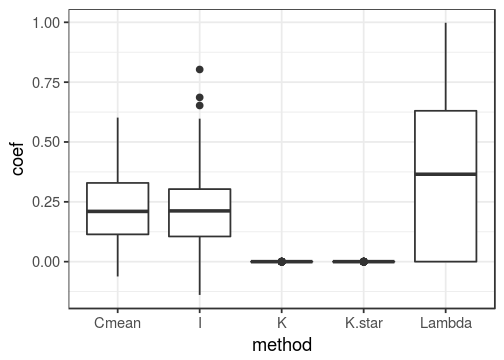

In [22]:
# plotting coef distribution
p = ggplot(physeq_res_j, aes(method, coef)) +
    geom_boxplot() +
    theme_bw()

options(repr.plot.width=4.2, repr.plot.height=3)
plot_write(p)

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/fig-1e18a2dd71809552ce804fb7.pdf 


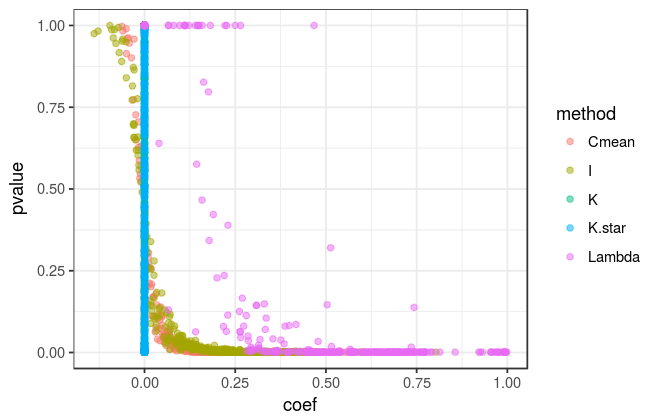

In [23]:
# plotting pvalue distribution
p = ggplot(physeq_res_j, aes(coef, pvalue, color=method)) +
    geom_point(alpha=0.5) +
    theme_bw()

options(repr.plot.width=5.5, repr.plot.height=3.5)
plot_write(p)

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/fig-4745434c2afac587881f6dbb.pdf 


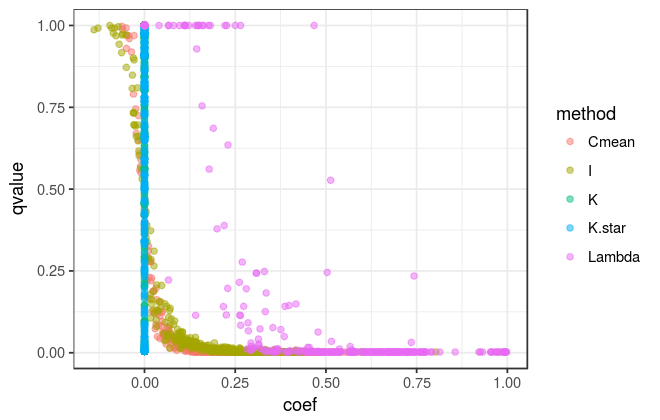

In [24]:
# plotting qvalue distribution
p = ggplot(physeq_res_j, aes(coef, qvalue, color=method)) +
    geom_point(alpha=0.5) +
    theme_bw()

options(repr.plot.width=5.5, repr.plot.height=3.5)
plot_write(p)

## Adding taxonomy

In [25]:
# tax = physeq %>%
#     tax_table %>%
#     as.matrix %>% 
#     as.data.frame

# tax$OTU = gsub('^([0-9])', 'X\\1', rownames(tax))
# rownames(tax) = 1:nrow(tax)

# tax %>% status

In [26]:
# to_rm = c('', 'uncultured', 'unclassified', 'Incertae Sedis', 
#           'uncultured bacterium', 'uncultured rumen bacterium')

In [27]:
physeq_res_j %>% nrow %>% print
physeq_res_j = physeq_res_j %>%
    inner_join(tax, c('OTU')) 

physeq_res_j %>% status

[1] 2040
[1] 2040   12


OTU,method,coef,pvalue,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species
X368bd5c2255f3a5ce0fef06ca6de1d04,Cmean,0.3817026,0.001,0.001773913,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
X779324e5648460c5a67e577c45131b42,Cmean,0.2297919,0.001,0.001773913,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
b918d185ee89a0b33d821ee766d76eb3,Cmean,0.1864239,0.001,0.001773913,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter


## Significant OTUs

### All 

In [28]:
physeq_res_j_f = physeq_res_j %>%
    filter(qvalue < 0.05) %>%
    group_by(OTU) %>%
    mutate(n_methods = method %>% unique %>% length) %>%
    ungroup() %>%
    mutate(Genus = Genus %>% as.character,
           Genus = Genus %>% reorder(Phylum %>% as.factor %>% as.numeric))

physeq_res_j_f %>% status

[1] 1111   13


OTU,method,coef,pvalue,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species,n_methods
X368bd5c2255f3a5ce0fef06ca6de1d04,Cmean,0.3817026,0.001,0.001773913,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,5
X779324e5648460c5a67e577c45131b42,Cmean,0.2297919,0.001,0.001773913,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,4
b918d185ee89a0b33d821ee766d76eb3,Cmean,0.1864239,0.001,0.001773913,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,2


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/phylosig_sig-OTUs_diet-resid.pdf 


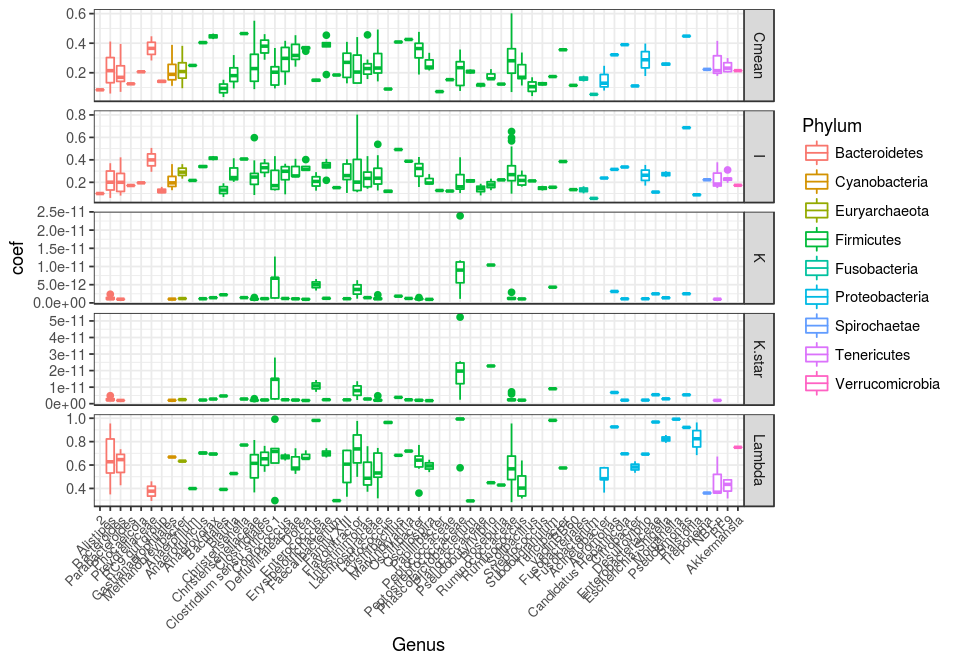

In [29]:
# plotting coef. values for each taxonomic group
p = ggplot(physeq_res_j_f, aes(Genus, coef, color=Phylum)) +
    geom_boxplot() +
    facet_grid(method ~ ., scales='free_y') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, size=8)
    )
        
options(repr.plot.width=8, repr.plot.height=5.5)
plot_write(p, file='phylosig_sig-OTUs_diet-resid.pdf')

In [30]:
physeq_res_j_f = physeq_res_j %>%
    filter(qvalue < 0.01,
           method == 'I') %>%
    group_by(OTU) %>%
    mutate(n_methods = method %>% unique %>% length) %>%
    ungroup() %>%
    mutate(Genus = Genus %>% as.character,
           Genus = Genus %>% reorder(Phylum %>% as.factor %>% as.numeric))

physeq_res_j_f %>% status

[1] 207  13


OTU,method,coef,pvalue,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species,n_methods
X368bd5c2255f3a5ce0fef06ca6de1d04,I,0.3618140,0.001,0.002550000,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,1
b918d185ee89a0b33d821ee766d76eb3,I,0.2904757,0.002,0.004716763,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter,1
f0f035365a85490145f397bf218afbab,I,0.2225770,0.004,0.008242424,Bacteria,Spirochaetae,Spirochaetes,Spirochaetales,Spirochaetaceae,Treponema,Treponema,1


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/phylosig_sig-OTUs_diet-resid_moranI.pdf 


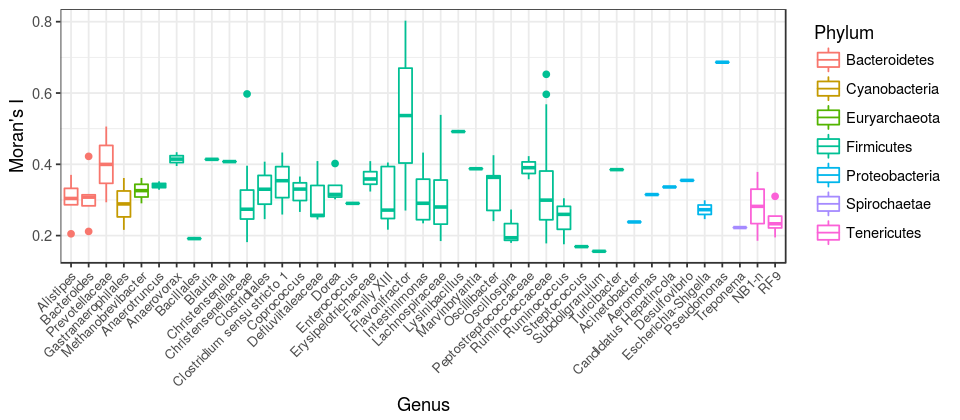

In [31]:
# plotting coef. values for each taxonomic group
p = ggplot(physeq_res_j_f, aes(Genus, coef, color=Phylum)) +
    geom_boxplot() +
    labs(y='Moran\'s I') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, size=8)
    )
        
options(repr.plot.width=8, repr.plot.height=3.5)
plot_write(p, file='phylosig_sig-OTUs_diet-resid_moranI.pdf')

# Phylosignal sensitivity analysis

* subsampling 1 sample per species

In [32]:
# subsampling tree
df = metadata %>%
    mutate(sample = rownames(.)) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_4d = plyr::llply(as.list(1:100), 
                  function(x) phylo4d_subsample(x, df, otu, host_tree),
                  .parallel=TRUE)
host_tree_4d %>% length

[1] 100

In [33]:
# phylosignal calculation
# WARNING: slow
methods = c("I")   # just moran's I
doParallel::registerDoParallel(threads)
#physeq_sub_res = plyr::llply(as.list(1:3), 
physeq_sub_res = plyr::llply(as.list(1:length(host_tree_4d)),
                             function(i) phyloSignal_each(i, host_tree_4d, methods=methods, reps=999),
                             .parallel=TRUE)

physeq_sub_res %>% length

[1] 100

In [34]:
physeq_sub_res = do.call(rbind, physeq_sub_res)
physeq_sub_res %>% status

[1] 40800     6


OTU,method,coef,pvalue,qvalue,subsample_rep
X368bd5c2255f3a5ce0fef06ca6de1d04,I,0.018696759,0.063,0.1093787,1
X779324e5648460c5a67e577c45131b42,I,0.016683512,0.061,0.1072759,1
b918d185ee89a0b33d821ee766d76eb3,I,-0.001522437,0.315,0.4241584,1


In [35]:
physeq_sub_res$method %>% table

.
    I 
40800 

### Saving resuls

In [36]:
out_file = file.path(work_dir, 'phylosignal_IndD_sens.RDS')
out_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//phylosignal_IndD_sens.RDS"

In [37]:
saveRDS(physeq_sub_res, out_file)
cat('File written:', out_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//phylosignal_IndD_sens.RDS 


In [38]:
# loading results
physeq_sub_res = readRDS(out_file)
physeq_sub_res %>% status

[1] 40800     6


OTU,method,coef,pvalue,qvalue,subsample_rep
X368bd5c2255f3a5ce0fef06ca6de1d04,I,0.018696759,0.063,0.1093787,1
X779324e5648460c5a67e577c45131b42,I,0.016683512,0.061,0.1072759,1
b918d185ee89a0b33d821ee766d76eb3,I,-0.001522437,0.315,0.4241584,1


## Adding taxonomy

In [39]:
physeq_sub_res %>% nrow %>% print

physeq_sub_res = physeq_sub_res %>%
    inner_join(tax, c('OTU')) 

physeq_sub_res %>% status

[1] 40800
[1] 40800    13


OTU,method,coef,pvalue,qvalue,subsample_rep,Domain,Phylum,Class,Order,Family,Genus,Species
X368bd5c2255f3a5ce0fef06ca6de1d04,I,0.018696759,0.063,0.1093787,1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
X779324e5648460c5a67e577c45131b42,I,0.016683512,0.061,0.1072759,1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
b918d185ee89a0b33d821ee766d76eb3,I,-0.001522437,0.315,0.4241584,1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter


In [40]:
physeq_sub_res %>% status

[1] 40800    13


OTU,method,coef,pvalue,qvalue,subsample_rep,Domain,Phylum,Class,Order,Family,Genus,Species
X368bd5c2255f3a5ce0fef06ca6de1d04,I,0.018696759,0.063,0.1093787,1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
X779324e5648460c5a67e577c45131b42,I,0.016683512,0.061,0.1072759,1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
b918d185ee89a0b33d821ee766d76eb3,I,-0.001522437,0.315,0.4241584,1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter


## Significant OTUs

In [41]:
## all OTUs with sig p-value in >= 95% of reps
physeq_sub_res_s = physeq_sub_res %>%
    group_by(OTU, method, Domain, Phylum, Class, Order, Family, Genus) %>%
    summarize(median_coef = median(coef),
              mean_coef = mean(coef),
              sd_coef = sd(coef),
              qvalue = (length(qvalue) - sum(qvalue < 0.05)) / length(qvalue)) %>%
    ungroup()

physeq_sub_res_s %>% status

[1] 408  12


OTU,method,Domain,Phylum,Class,Order,Family,Genus,median_coef,mean_coef,sd_coef,qvalue
a00218cf61edc4c39ad85d492251426f,I,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,0.07544669,0.07501796,0.01036580,0.00
a01db188e170d6297f7e939e7c73be61,I,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Peptostreptococcaceae,-0.01498918,-0.01479190,0.00141530,1.00
a36392611a398d344696b8ab75fe4d08,I,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,0.06593391,0.06422759,0.01560708,0.03


In [42]:
# check: one value per OTU + method?
physeq_sub_res_s %>%
    group_by(OTU, method) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    .$n %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

In [43]:
# number of significant OTUs
n_sig_OTUs = physeq_sub_res_s %>%
    filter(qvalue < 0.05) %>%
    distinct(OTU) %>%
    nrow

cat('Number of globally sig. OTUs:', n_sig_OTUs, '\n')

Number of globally sig. OTUs: 94 


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/phylosignal_IndD_sens_nOTUs.pdf 


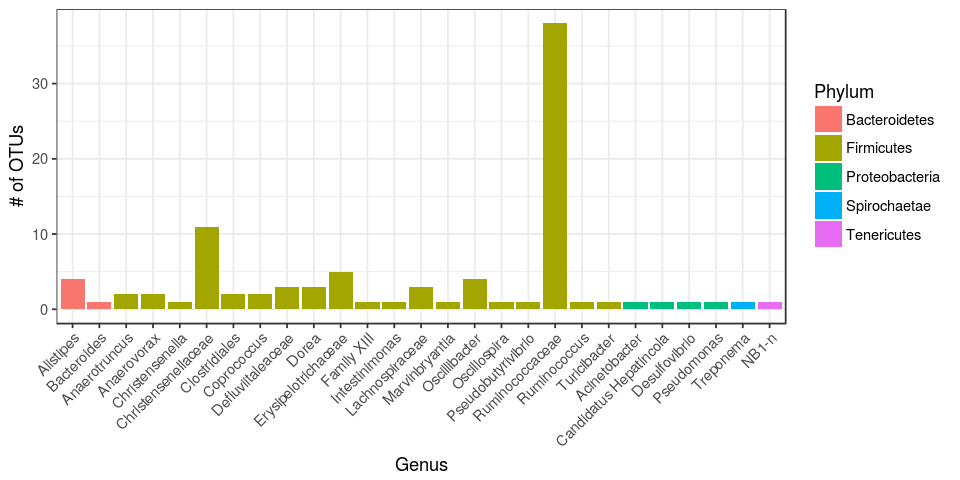

In [44]:
# summary
p = ggplot(physeq_sub_res_s %>% 
               filter(qvalue < 0.05) %>%
               mutate(Genus = Genus %>% reorder(Phylum %>% as.factor %>% as.numeric)), 
           aes(Genus, fill=Phylum)) +
    geom_bar() +
    labs(y='# of OTUs') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=8, repr.plot.height=4)
plot_write(p, file='phylosignal_IndD_sens_nOTUs.pdf')

# Location on host tree

Measuring local phylogenetic signal

In [45]:
# convert to phylo4d
host_tree_4d = phylobase::phylo4d(host_tree, tip.data=t(otu))
host_tree_4d %>% summary

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Warning message in checkTree(object):
“Labels are not unique. ”Warning message in checkTree(object):
“Labels are not unique. ”

 Length   Class    Mode 
      1 phylo4d      S4 

## `lipaMoran`

In [46]:
lipaMoran_per_OTU = function(trait, tree_4d, reps=9999){
    res = lipaMoran(tree_4d, trait=trait, reps=reps, prox.phylo = "nNodes")
    z = colnames(res$lipa)[1]
    x = res$lipa
    colnames(x) = c('coef')
    y = res$p.value 
    colnames(y) = c('pvalue')
    df = cbind(x,y) %>% as.data.frame
    df$OTU = z
    df$host = rownames(df)
    rownames(df) = 1:nrow(df)
    return(df)
}

traits = physeq_res_j_f$OTU %>% unique
traits %>% length

[1] 207

In [47]:
# running in parallel
registerDoParallel(cores=threads)
lipa_res = plyr::llply(as.list(traits), lipaMoran_per_OTU, 
                       tree_4d=host_tree_4d,
                       reps=9999,
                       .parallel=TRUE)
lipa_res = do.call(rbind, lipa_res)
lipa_res %>% status

[1] 44091     4


coef,pvalue,OTU,host
0.1147636,0.0134,X368bd5c2255f3a5ce0fef06ca6de1d04,X256.Zander
0.1450291,0.0180,X368bd5c2255f3a5ce0fef06ca6de1d04,F302.Northern.Pike
0.1519161,0.0165,X368bd5c2255f3a5ce0fef06ca6de1d04,X188.Brook.Trout


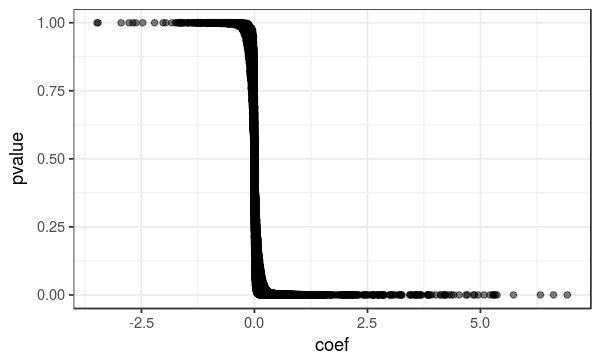

In [48]:
# plotting pvalue ~ coef
p = ggplot(lipa_res, aes(coef, pvalue)) +
    geom_point(alpha=0.5) +
    theme_bw() 

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [49]:
# adjusting p-values
lipa_res$qvalue = p.adjust(lipa_res$pvalue, method='BH')
lipa_res$qvalue %>% summary

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004293 0.139534 0.498766 0.480130 0.761114 1.000000 

In [50]:
# significant OTUs
lipa_res_f = lipa_res %>%
    filter(qvalue < 0.05) %>%
    inner_join(tax, c('OTU'))

lipa_res_f %>% status

[1] 6710   12


coef,pvalue,OTU,host,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species
0.10820008,0.0075,X368bd5c2255f3a5ce0fef06ca6de1d04,X350.Smooth.Newt,0.04951078,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
0.08960636,0.0043,X368bd5c2255f3a5ce0fef06ca6de1d04,X362.Gray.Four.eyed.Opossum,0.03585990,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter
0.20688900,0.0035,X368bd5c2255f3a5ce0fef06ca6de1d04,X415.White.Rhinoceros,0.03191696,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter


In [51]:
# number of significant OTUs
lipa_res_f$OTU %>% unique %>% length

[1] 207

### Formatting for iTOL


Setting initial dates...
Fitting in progress... get a first set of estimates
         Penalised log-lik = -310.7802 
Optimising rates... dates... -310.7802 

Done.


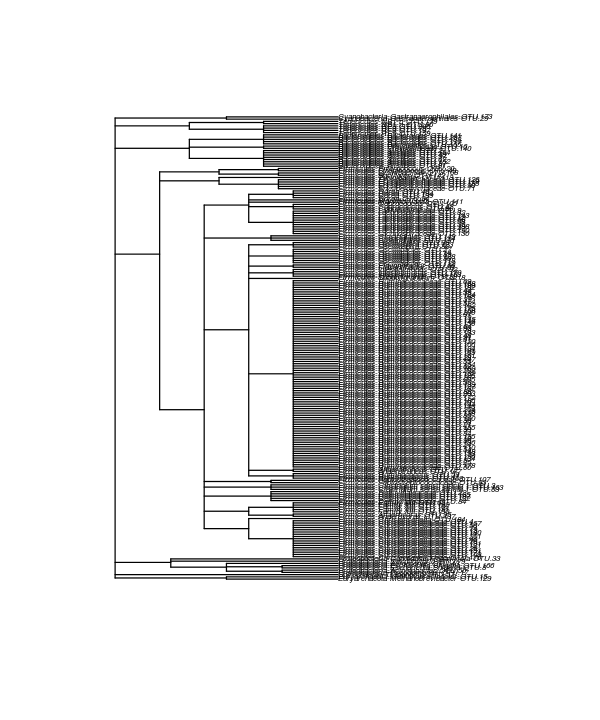

In [52]:
# creating cladogram of taxa
to_rm = c('unclassified', 'uncultured')
tmp = lipa_res_f %>%
    distinct(Domain, Phylum, Class, Order, Family, Genus, OTU) %>%
    mutate(OTU_ID = gsub('^', 'OTU.', OTU %>% as.factor %>% as.numeric)) %>%
    mutate(Family = Family %>% as.character,
           Genus = Genus %>% as.character,
           Genus = ifelse(Genus %in% to_rm, Family, Genus)) %>%
    unite('Genus_OTU', c('Phylum', 'Genus', 'OTU_ID'), sep='-', remove=FALSE) %>%
    mutate(Domain = Domain %>% as.factor,
           Phylum = Phylum %>% as.factor,
           Class = Class %>% as.factor,
           Order = Order %>% as.factor,
           Family = Family %>% as.factor,
           Genus = Genus %>% as.factor,
           Genus_OTU = Genus_OTU %>% as.factor) 

clado = as.phylo(~Phylum/Class/Order/Family/Genus/Genus_OTU, data=tmp)
clado = compute.brlen(clado, 1)
clado = chronos(clado)
options(repr.plot.height=6)
plot(clado, cex=0.4)

In [53]:
lipa_res_f_s = lipa_res_f %>% 
    inner_join(tmp %>% dplyr::select(OTU, Genus_OTU), c('OTU')) %>%
    dplyr::select(Genus_OTU, host, coef) %>%
    spread(Genus_OTU, coef) %>%
    right_join(data.frame(tips = host_tree$tip.label), 
               c('host'='tips')) 

rownames(lipa_res_f_s) = gsub('X([0-9])', '\\1', lipa_res_f_s$host)
lipa_res_f_s$host = NULL
lipa_res_f_s %>% status

Warning message:
“Column `host`/`tips` joining character vector and factor, coercing into character vector”

[1] 213 207


,Bacteroidetes-Alistipes-OTU.152,Bacteroidetes-Alistipes-OTU.164,Bacteroidetes-Alistipes-OTU.2,Bacteroidetes-Alistipes-OTU.45,Bacteroidetes-Alistipes-OTU.67,Bacteroidetes-Alistipes-OTU.81,Bacteroidetes-Alistipes-OTU.87,Bacteroidetes-Alistipes-OTU.97,Bacteroidetes-Bacteroides-OTU.117,Bacteroidetes-Bacteroides-OTU.141,⋯,Proteobacteria-Escherichia-Shigella-OTU.166,Proteobacteria-Escherichia-Shigella-OTU.8,Proteobacteria-Pseudomonas-OTU.17,Spirochaetae-Treponema-OTU.57,Tenericutes-NB1-n-OTU.179,Tenericutes-NB1-n-OTU.86,Tenericutes-RF9-OTU.159,Tenericutes-RF9-OTU.197,Tenericutes-RF9-OTU.206,Tenericutes-RF9-OTU.75
256.Zander,NA,NA,0.1406994,NA,0.1640455,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
F302.Northern.Pike,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
188.Brook.Trout,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [54]:
itol_htmp_file = file.path(work_dir, 'IndD_lipaMoran_sig_htmp.txt')
labs = gsub(' ', '_', colnames(lipa_res_f_s))
labs = sprintf('FIELD_LABELS %s\n', paste(labs, collapse=' '))

cat('DATASET_HEATMAP\n', file=itol_htmp_file)
cat('SEPARATOR SPACE\n', file=itol_htmp_file, append=TRUE)
cat('DATASET_LABEL local_Morans_I\n', file=itol_htmp_file, append=TRUE)
cat('COLOR #ff0000\n', file=itol_htmp_file, append=TRUE)
cat(labs, file=itol_htmp_file, append=TRUE)

cat('FIELD_TREE ', file=itol_htmp_file, append=TRUE)
write.tree(clado, file=itol_htmp_file, append=TRUE)
cat('DATA\n', file=itol_htmp_file, append=TRUE)
write.table(lipa_res_f_s, file=itol_htmp_file, append=TRUE, sep=' ', 
            quote=FALSE, col.names=FALSE)

cat('File written:', itol_htmp_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//IndD_lipaMoran_sig_htmp.txt 


## `lipaMoran` sensitivity analysis

In [55]:
# subsampling trees (1 sample per species)
df = metadata %>%
    mutate(sample = X.SampleID) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_4d = plyr::llply(as.list(1:100), 
                  function(x) phylo4d_subsample(x, df, otu, host_tree),
                  .parallel=TRUE)
host_tree_4d %>% length

[1] 100

In [56]:
# phylosignal calculation
## WARNING: SLOW
lipa_sub_res = plyr::llply(as.list(1:length(host_tree_4d)), 
                           function(i) lipamoran_each(i, host_tree_4d, traits=traits, reps=9999))

lipa_sub_res = do.call(rbind, lipa_sub_res)
lipa_sub_res %>% status

[1] 2649600       5


coef,pvalue,OTU,host,subsample_rep
0.15861973,0.0291,X368bd5c2255f3a5ce0fef06ca6de1d04,F302.Northern.Pike,1
0.16235677,0.0269,X368bd5c2255f3a5ce0fef06ca6de1d04,X188.Brook.Trout,1
0.04501877,0.1561,X368bd5c2255f3a5ce0fef06ca6de1d04,F300.Asp,1


### Saving results

In [57]:
out_file = file.path(work_dir, 'lipaMoran_IndD_sens.RDS')
out_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//lipaMoran_IndD_sens.RDS"

In [58]:
saveRDS(lipa_sub_res, out_file)
cat('File written:', out_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//lipaMoran_IndD_sens.RDS 


In [85]:
# loading results
lipa_sub_res = readRDS(out_file)
lipa_sub_res %>% status

[1] 2649600       5


coef,pvalue,OTU,host,subsample_rep
0.15861973,0.0291,X368bd5c2255f3a5ce0fef06ca6de1d04,F302.Northern.Pike,1
0.16235677,0.0269,X368bd5c2255f3a5ce0fef06ca6de1d04,X188.Brook.Trout,1
0.04501877,0.1561,X368bd5c2255f3a5ce0fef06ca6de1d04,F300.Asp,1


In [86]:
#send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/phylosignal/host_TT/3_OTU_phylosignal_IndD.ipynb')

### Adding host data

In [87]:
lipa_sub_res %>% nrow %>% print

lipa_sub_res = lipa_sub_res %>%
    inner_join(metadata %>% dplyr::select(Sample_ID, class, order, family, genus, scientific_name),
               c('host'='Sample_ID')) 
               
lipa_sub_res %>% status

[1] 2649600
[1] 2649600      10


coef,pvalue,OTU,host,subsample_rep,class,order,family,genus,scientific_name
0.15861973,0.0291,X368bd5c2255f3a5ce0fef06ca6de1d04,F302.Northern.Pike,1,Actinopterygii,Esociformes,Esocidae,Esox,Esox_lucius
0.16235677,0.0269,X368bd5c2255f3a5ce0fef06ca6de1d04,X188.Brook.Trout,1,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus,Salvelinus_fontinalis
0.04501877,0.1561,X368bd5c2255f3a5ce0fef06ca6de1d04,F300.Asp,1,Actinopterygii,Cypriniformes,Cyprinidae,Aspius,Aspius_aspius


### Significant OTUs

In [88]:
# sample size per group
lipa_sub_res %>%
    group_by(OTU, scientific_name) %>%
    summarize(n=n()) %>%
    .$n %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4.00   44.75  100.00  100.00  108.75  569.00 

In [89]:
# q-value adjustment
lipa_sub_res %>%
    group_by(subsample_rep) %>%
    mutate(pvalue = pvalue %>% as.Num,
           qvalue = p.adjust(pvalue, method='BH')) %>%
    ungroup() %>%
    .$qvalue %>% summary

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.003925 0.184224 0.520827 0.496233 0.763203 1.000000 

In [90]:
# q-value adjustment
lipa_sub_res = lipa_sub_res %>%
    group_by(subsample_rep) %>%
    mutate(pvalue = pvalue %>% as.Num,
           qvalue = p.adjust(pvalue, method='BH')) %>%
    ungroup() 

lipa_sub_res %>% status

[1] 2649600      11


coef,pvalue,OTU,host,subsample_rep,class,order,family,genus,scientific_name,qvalue
0.15861973,0.0291,X368bd5c2255f3a5ce0fef06ca6de1d04,F302.Northern.Pike,1,Actinopterygii,Esociformes,Esocidae,Esox,Esox_lucius,0.1497734
0.16235677,0.0269,X368bd5c2255f3a5ce0fef06ca6de1d04,X188.Brook.Trout,1,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus,Salvelinus_fontinalis,0.1424061
0.04501877,0.1561,X368bd5c2255f3a5ce0fef06ca6de1d04,F300.Asp,1,Actinopterygii,Cypriniformes,Cyprinidae,Aspius,Aspius_aspius,0.4274962


In [91]:
## all OTUs with sig p-value in >= 95% of reps
lipa_sub_res_s = lipa_sub_res %>%
    group_by(OTU, scientific_name) %>%
    summarize(median_coef = median(coef),
              mean_coef = mean(coef),
              sd_coef = sd(coef),
              qvalue = (length(qvalue) - sum(qvalue < 0.05)) / length(qvalue)) %>%
    ungroup() 

lipa_sub_res_s %>% status

[1] 26496     6


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue
a00218cf61edc4c39ad85d492251426f,Acrocephalus_scirpaceus,-0.03559695,-0.02442908,0.03641030,1
a00218cf61edc4c39ad85d492251426f,Aepyceros_melampus,0.39458774,0.39696315,0.02881974,0
a00218cf61edc4c39ad85d492251426f,Anas_platyrhynchos,0.04412080,0.04146506,0.02668509,1


In [92]:
#lipa_sub_res_s$pvalue %>% summary %>% print
lipa_sub_res_s$qvalue %>% summary %>% print
lipa_sub_res_s$OTU %>% unique %>% length %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9274  1.0000  1.0000 
[1] 207


In [93]:
# filtering to just significant values
lipa_sub_res_s = lipa_sub_res_s %>%
    filter(qvalue < 0.05) 

n_sig_OTUs = lipa_sub_res_s$OTU %>% unique %>% length
cat('Number of sig. OTUs:', n_sig_OTUs, '\n')
lipa_sub_res_s %>% status

Number of sig. OTUs: 155 
[1] 522   6


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue
a00218cf61edc4c39ad85d492251426f,Aepyceros_melampus,0.3945877,0.3969632,0.02881974,0
a00218cf61edc4c39ad85d492251426f,Capra_ibex,0.4739101,0.4789139,0.04739004,0
a00218cf61edc4c39ad85d492251426f,Dama_dama,0.3706631,0.3683270,0.05501600,0



### Just globally-significant OTUs

In [94]:
# skipping
lipa_sub_res_s_j = lipa_sub_res_s 

In [95]:
# # just globally significant OTUs 
# lipa_sub_res_s_j = lipa_sub_res_s %>%
#     semi_join(physeq_sub_res_s %>% filter(qvalue < 0.05),
#               c('OTU')) 

# lipa_sub_res_s_j$qvalue %>% summary
# cat('Number of OTUs:', lipa_sub_res_s_j$OTU %>% unique %>% length, '\n')
# lipa_sub_res_s_j %>% status

### Adding OTU taxonomy

In [96]:
lipa_sub_res_s_j %>% nrow %>% print

lipa_sub_res_s_j = lipa_sub_res_s_j %>%
    inner_join(tax, c('OTU')) 

lipa_sub_res_s_j %>% status

[1] 522
[1] 522  13


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species
a00218cf61edc4c39ad85d492251426f,Aepyceros_melampus,0.3945877,0.3969632,0.02881974,0,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae
a00218cf61edc4c39ad85d492251426f,Capra_ibex,0.4739101,0.4789139,0.04739004,0,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae
a00218cf61edc4c39ad85d492251426f,Dama_dama,0.3706631,0.3683270,0.05501600,0,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae


### adding host data (again)

In [97]:
lipa_sub_res_s_j %>% nrow %>% print

lipa_sub_res_s_j = lipa_sub_res_s_j %>%
    inner_join(metadata %>% dplyr::distinct(class, order, family, genus, scientific_name),
               c('scientific_name'))
            
lipa_sub_res_s_j %>% status

[1] 522
[1] 522  17


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species,class,order,family,genus
a00218cf61edc4c39ad85d492251426f,Aepyceros_melampus,0.3945877,0.3969632,0.02881974,0,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Aepyceros
a00218cf61edc4c39ad85d492251426f,Capra_ibex,0.4739101,0.4789139,0.04739004,0,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Capra
a00218cf61edc4c39ad85d492251426f,Dama_dama,0.3706631,0.3683270,0.05501600,0,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Cervidae,Dama


### Summary

In [98]:
# number of OTUs
lipa_sub_res_s_j$OTU %>% unique %>% length

[1] 155

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/.figures/lipamoran_sigOTUs_byClass.pdf 


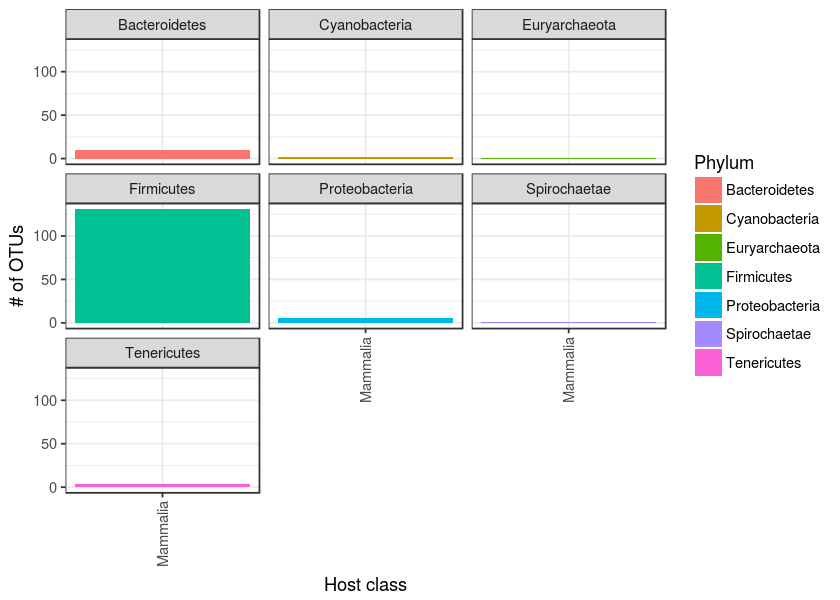

In [99]:
# summary plot by (class)
lipa_sub_res_s_j_s = lipa_sub_res_s_j %>%
    distinct(class, Phylum, OTU) %>%
    group_by(class, Phylum) %>%
    summarize(n=n()) %>%
    ungroup()

p = ggplot(lipa_sub_res_s_j_s, aes(class, n, fill=Phylum)) +
    geom_bar(stat='identity') +
    labs(x='Host class', y='# of OTUs') +
    facet_wrap(~ Phylum) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5)
    )

options(repr.plot.width=7, repr.plot.height=5)
plot_write(p, file='lipamoran_sigOTUs_byClass.pdf')

In [100]:
# number of OTUs per sample
lipa_sub_res_s_j %>%
    distinct(scientific_name, OTU) %>%
    group_by(scientific_name) %>%
    summarize(n_OTUs = OTU %>% length) %>%
    ungroup() %>%
    .$n_OTUs %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.75    4.00   16.31   25.50   84.00 

### Formatting for iTOL

#### Number of OTUs per species

* OTUs grouped at phylum level

In [101]:
lipa_sub_res_s_j_s = lipa_sub_res_s_j %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name)) %>%
    group_by(scientific_name, Phylum) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    spread(Phylum, n, fill=0) %>%
    as.data.frame

rownames(lipa_sub_res_s_j_s) = lipa_sub_res_s_j_s$scientific_name
lipa_sub_res_s_j_s$scientific_name = NULL
lipa_sub_res_s_j_s %>% status

[1] 32  7


,Bacteroidetes,Cyanobacteria,Euryarchaeota,Firmicutes,Proteobacteria,Spirochaetae,Tenericutes
Aepyceros_melampus,4,1,0,76,2,0,1
Apodemus_sylvaticus,0,0,0,1,0,0,0
Bos_frontalis,0,0,0,1,0,0,0


In [102]:
itol_multibar(lipa_sub_res_s_j_s, 'lipaMoran_number_OTUs', 
              'lipaMoran-IndD-sens_phylum-multibar.txt', work_dir)

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//lipaMoran-IndD-sens_phylum-multibar.txt 


#### Heatmap of OTUs

In [103]:
lipa_sub_res_s_j %>% status

[1] 522  17


OTU,scientific_name,median_coef,mean_coef,sd_coef,qvalue,Domain,Phylum,Class,Order,Family,Genus,Species,class,order,family,genus
a00218cf61edc4c39ad85d492251426f,Aepyceros_melampus,0.3945877,0.3969632,0.02881974,0,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Aepyceros
a00218cf61edc4c39ad85d492251426f,Capra_ibex,0.4739101,0.4789139,0.04739004,0,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Bovidae,Capra
a00218cf61edc4c39ad85d492251426f,Dama_dama,0.3706631,0.3683270,0.05501600,0,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae,Ruminococcaceae,Mammalia,Artiodactyla,Cervidae,Dama



Setting initial dates...
Fitting in progress... get a first set of estimates
         Penalised log-lik = -591.782 
Optimising rates... dates... -591.782 
Optimising rates... dates... -591.782 

Done.


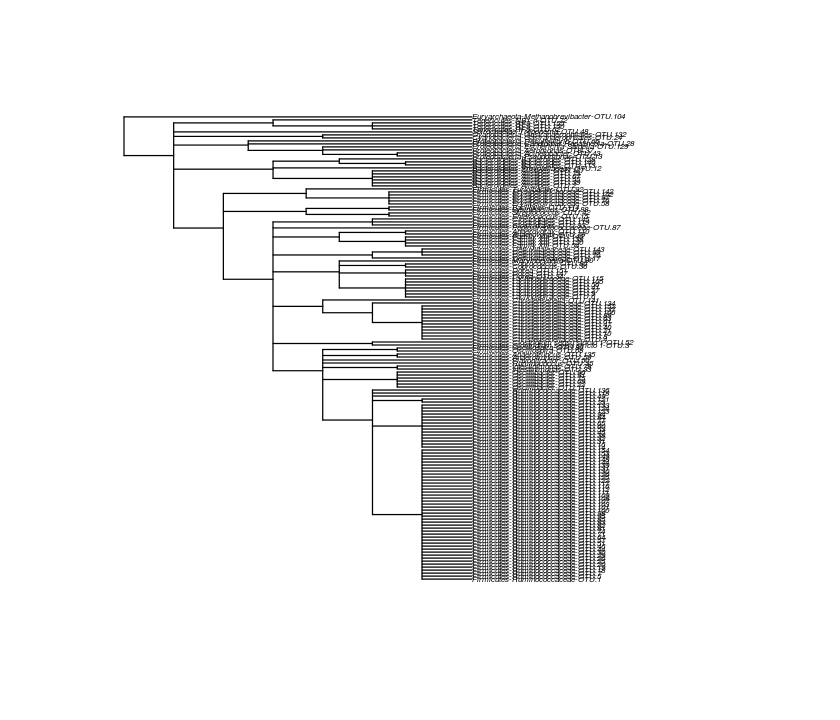

In [104]:
# creating cladogram of taxa
tmp = lipa_sub_res_s_j %>%
    distinct(Domain, Phylum, Class, Order, Family, Genus, Species, OTU) %>%
    mutate(OTU_ID = gsub('^', 'OTU.', OTU %>% as.factor %>% as.numeric)) %>%
    unite('Genus_OTU', c('Phylum', 'Genus', 'OTU_ID'), sep='-', remove=FALSE) %>%
    mutate(Domain = Domain %>% as.factor,
           Phylum = Phylum %>% as.factor,
           Class = Class %>% as.factor,
           Order = Order %>% as.factor,
           Family = Family %>% as.factor,
           Genus = Genus %>% as.factor,
           Species = Species %>% as.factor,
           Genus_OTU = Genus_OTU %>% as.factor) 

clado = as.phylo(~Domain/Phylum/Class/Order/Family/Genus/Species/Genus_OTU, data=tmp)
clado = compute.brlen(clado, 1)
clado = chronos(clado)
options(repr.plot.height=6)
plot(clado, cex=0.4)

In [106]:
# 16S tree
tree16S = physeq %>% phy_tree
tree16S$tip.label = gsub('^([0-9])', 'X\\1', tree16S$tip.label)

# filtering
to_rm = setdiff(tree16S$tip.label, lipa_sub_res_s_j$OTU)
tree16S = drop.tip(tree16S, to_rm)

# renaming
x = tmp %>% dplyr::select(OTU, Genus_OTU) %>% as.data.frame
rownames(x) = x$OTU
tree16S$tip.label = x[tree16S$tip.label, 'Genus_OTU']

# status
tree16S


Phylogenetic tree with 155 tips and 154 internal nodes.

Tip labels:
	Euryarchaeota-Methanobrevibacter-OTU.104, Spirochaetae-Treponema-OTU.48, Proteobacteria-Pseudomonas-OTU.13, Proteobacteria-Escherichia-Shigella-OTU.129, Proteobacteria-Aeromonas-OTU.37, Proteobacteria-Acinetobacter-OTU.43, ...
Node labels:
	0.435, 0.895, 0.812, 0.941, 0.971, 0.695, ...

Rooted; includes branch lengths.

In [107]:
# one row per OTU-host?
lipa_sub_res_s_j %>%
    group_by(OTU, scientific_name) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    .$n %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

In [108]:
# formatting data frame
lipa_sub_res_s_j_f = lipa_sub_res_s_j %>% 
    mutate(scientific_name = gsub(' ', '_',  scientific_name)) %>%
    inner_join(tmp %>% dplyr::select(OTU, Genus_OTU), c('OTU')) %>%
    dplyr::select(Genus_OTU, scientific_name, mean_coef) %>%
    spread(Genus_OTU, mean_coef) %>%
    as.data.frame

#rownames(lipa_sub_res_s_j_f) = gsub('X([0-9])', '\\1', lipa_sub_res_s_j_f$scientific_name)
rownames(lipa_sub_res_s_j_f) = lipa_sub_res_s_j_f$scientific_name
lipa_sub_res_s_j_f$scientific_name = NULL
lipa_sub_res_s_j_f %>% status

[1]  32 155


,Bacteroidetes-Alistipes-OTU.127,Bacteroidetes-Alistipes-OTU.2,Bacteroidetes-Alistipes-OTU.39,Bacteroidetes-Alistipes-OTU.55,Bacteroidetes-Alistipes-OTU.67,Bacteroidetes-Alistipes-OTU.73,Bacteroidetes-Bacteroides-OTU.113,Bacteroidetes-Bacteroides-OTU.128,Bacteroidetes-Bacteroides-OTU.140,Bacteroidetes-Prevotellaceae-OTU.12,⋯,Proteobacteria-Aeromonas-OTU.37,Proteobacteria-Candidatus Hepatincola-OTU.28,Proteobacteria-Desulfovibrio-OTU.66,Proteobacteria-Escherichia-Shigella-OTU.129,Proteobacteria-Pseudomonas-OTU.13,Spirochaetae-Treponema-OTU.48,Tenericutes-NB1-n-OTU.72,Tenericutes-RF9-OTU.150,Tenericutes-RF9-OTU.155,Tenericutes-RF9-OTU.62
Aepyceros_melampus,NA,0.3276812,NA,0.3580396,0.2407604,NA,NA,NA,0.3158142,NA,⋯,NA,0.3435621,0.3503259,NA,NA,NA,NA,NA,0.2446796,NA
Apodemus_sylvaticus,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Bos_frontalis,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [109]:
itol_heatmap(lipa_sub_res_s_j_f, 'lipaMoran_OTU', 
              'lipaMoran-IndD-sens_OTU-htmap.txt', work_dir,
              tree=clado)

Warning message in if (color_scheme == "color") {:
“the condition has length > 1 and only the first element will be used”

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//lipaMoran-IndD-sens_OTU-htmap.txt 


In [110]:
itol_heatmap(lipa_sub_res_s_j_f, 'lipaMoran_OTU_16S', 
              'lipaMoran-IndD-sens_OTU-htmap-16S.txt', work_dir,
              tree=tree16S)

Warning message in if (color_scheme == "color") {:
“the condition has length > 1 and only the first element will be used”

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//lipaMoran-IndD-sens_OTU-htmap-16S.txt 


# sessionInfo

In [111]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_physig/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_physig/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bindrcpp_0.2      doParallel_1.0.10 iterators_1.0.8   foreach_1.4.3    
 [5] phylosignal_1.2   phyloseq_1.22.3   ape_5.0           ggplot2_2.2.1    
 [9] tidyr_0.7.1       dplyr_0